# Reaging GANs

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import typing
import wandb
import os
from tqdm.notebook import tqdm
import cv2
import time

# wandb.login()

%load_ext watermark
%watermark -a "Aneesh Aparajit G" -p torch,typing,wandb,tqdm,cv2,os,time

Author: Aneesh Aparajit G

torch : 1.12.0
typing: unknown
wandb : 0.13.4
tqdm  : 4.64.0
cv2   : 4.6.0
os    : unknown
time  : unknown



# Utilities

## Convolutional Block

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 2) -> None:
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=False)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

## Transpose Convolutional Block

In [3]:
class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 2) -> None:
        super(TransposeConvBlock, self).__init__()
        self.tran_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, 
                               stride=stride, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.tran_conv(x)

# Discriminator

In [4]:
class Discriminator(nn.Module):
    '''Implementation is the same as Pix2Pix

    The forward method will have the the input image and the target image.
        - The target image may not be of the same person, so as result, we'll consider a few more loss functions like the reconstruction loss.
    '''
    def __init__(self, in_channels: int = 3, features: tuple = (64, 128, 256, 512), input_size: int = 128, num_age_groups: int = 3) -> None:
        super(Discriminator, self).__init__()
        self.inital = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2 + 2, out_channels=features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=False)
        )

        layers = []
        in_channels = features[0]

        for ix in range(1, len(features), 1):
            if ix == len(features) - 1:
                layers.append(ConvBlock(in_channels=in_channels, out_channels=features[ix], stride=1))
            else:
                layers.append(ConvBlock(in_channels=in_channels, out_channels=features[ix]))
            in_channels = features[ix]

        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=4, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

        self.input_size = input_size
        
        self.input_embed = nn.Embedding(num_embeddings=num_age_groups, embedding_dim=self.input_size ** 2)
        self.output_embed = nn.Embedding(num_embeddings=num_age_groups, embedding_dim=self.input_size ** 2)

    
    def forward(self, input_img: torch.Tensor, input_age: torch.Tensor, output_img: torch.Tensor, output_age: torch.Tensor) -> torch.Tensor:
        '''This is the forward call of the Discriminator
        
        Args:
        ----
            - input_tensor : Tuple[torch.Tensor, torch.Tensor]
                - The first element is the input image
                - The second element is the input age

            - output_tensor : Tuple[torch.Tensor, torch.Tensor]
                - The first element is the output image
                - The second element is the output age

        The considered solution, is similar to the original "Conditional Paper".
            - In this implementation, what we do is, we pass the input age embedding, output image, output age embedding.
                - The idea behind this is that the model will eventually learn the correlation between the pixel values in the input age, output image and the age groups.
                - Here, we can use a single age embedding layer, but I want to experiment with two different embedding layers of the input age and the output age.

        '''

        input_age_embed = self.input_embed(input_age).reshape(-1, 1, self.input_size, self.input_size)
        output_age_embed = self.output_embed(output_age).reshape(-1, 1, self.input_size, self.input_size)

        X = torch.cat([input_img, input_age_embed], dim=1)
        y = torch.cat([output_img, output_age_embed], dim=1)

        x = torch.cat([X, y], dim=1)
        x = self.inital(x)
        return self.model(x)

In [5]:
def test():
    X_img = torch.randn((5, 3, 256, 256))
    X_age = torch.LongTensor([2, 2, 1, 1, 2])

    y_img = torch.randn((5, 3, 256, 256))
    y_age = torch.LongTensor([2, 2, 0, 1, 2])
    
    model = Discriminator(input_size=256)
    
    print(f'\n[PROCESSING THE DATA...]\n')
    
    z = model.forward(X_img, X_age, y_img, y_age)
    
#     print(model)

    print(f'z: {z.shape}')
    
test()


[PROCESSING THE DATA...]

z: torch.Size([5, 1, 30, 30])


# Generator

In [6]:
class Generator(nn.Module):
    """This is essentially a U-Net type architecture. But, we'll pass the input age and the output age as well.
    
    So, if the in_channels = 3, then we'll pass 5 channels in the model.
        - 1 will be for the input_age embedding.
        - 2 will be for the output_age embedding.
    
    """

    def __init__(self, in_channels: int = 3, num_age_groups: int = 3, input_size: int = 128) -> None:
        super(Generator, self).__init__()
        
        self.input_embed = nn.Embedding(num_embeddings=num_age_groups, embedding_dim=input_size*input_size)
        self.output_embed = nn.Embedding(num_embeddings=num_age_groups, embedding_dim=input_size*input_size)
        self.input_size = input_size
        
        self.init_down = ConvBlock(in_channels=in_channels + 2, out_channels=64) # 5 -> 64
        
        self.down1 = ConvBlock(in_channels=64, out_channels=128) # 64 -> 128
        self.down2 = ConvBlock(in_channels=128, out_channels=256) # 128 -> 256
        self.down3 = ConvBlock(in_channels=256, out_channels=512) # 256 -> 512
        self.down4 = ConvBlock(in_channels=512, out_channels=512) # 512 -> 512
        self.down5 = ConvBlock(in_channels=512, out_channels=512) # 512 -> 512
        self.down6 = ConvBlock(in_channels=512, out_channels=512) # 512 -> 512
        
        # bottle neck
        self.bottle_neck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=0.2, inplace=False)
        ) #
        
        self.up1 = TransposeConvBlock(in_channels=512, out_channels=512) # 512 -> 512
        self.up2 = TransposeConvBlock(in_channels=1024, out_channels=512) # 512 -> 1024
        self.up3 = TransposeConvBlock(in_channels=1024, out_channels=512) # 1024 -> 1024
        self.up4 = TransposeConvBlock(in_channels=1024, out_channels=512) # 1024 -> 512
        self.up5 = TransposeConvBlock(in_channels=1024, out_channels=256) # 512 -> 256
        self.up6 = TransposeConvBlock(in_channels=512, out_channels=128) # 256 -> 128
        self.up7 = TransposeConvBlock(in_channels=256, out_channels=64) # 128 -> 64
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ) # 64 -> 3
    
    def forward(self, x: torch.Tensor, input_age: torch.Tensor, output_age: torch.Tensor) -> torch.Tensor:
        
        inp_embed = self.input_embed(input_age).reshape(input_age.shape[0], 1, self.input_size, self.input_size)
        out_embed = self.output_embed(output_age).reshape(output_age.shape[0], 1, self.input_size, self.input_size)
        
        y = torch.cat([x, inp_embed, out_embed], dim=1)
        d1 = self.init_down(y)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottle_neck = self.bottle_neck(d7)
        u1 = self.up1(bottle_neck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        return self.final_up(torch.cat([u7, d1], dim=1))

In [7]:
def test():
    X_img = torch.randn((1, 3, 256, 256))
    X_age = torch.tensor([[2]])
    y_age = torch.tensor([[1]])
    
    model = Generator(input_size=256)

    print(f'\n[PROCESSING THE DATA...]\n')
    
    z = model.forward(X_img, X_age, y_age)

    print(f'z: {z.shape}')
    
test()


[PROCESSING THE DATA...]

z: torch.Size([1, 3, 256, 256])


# Optimization / Loss function

The framework operates on three input information, an input image $x$ and its corresponding age label $y$, and randomly sampled target age $y'$ into which input should be transformed. Subsequently, given this information, G will produce __age-transformed $x'$__, __reconstructed $x_{rec}$__, and __cycle-consistency images $x_{cycle}$__ as 

$$x'=G(x,y')$$

$$x_{rec}=G(x,y)$$

$$x_{cycle}=G(x',y)$$

## Reconstruction loss

$$\mathcal{L}_{rec}(G) = \|x-x_{rec}\|_1$$


## Cycle-Consistency loss

$$\mathcal{L}_{cyc}(G) = \|x-x_{cycle}\|_1$$

## Adversarial loss

$$\mathcal{L}_{adv}(G,D)=\mathbb{E}_{x,y}[\log D_y(x)] + \mathbb{E}_{x,y'}[\log(1-D_{y'}(x'))]$$


# Custom Training Loop

In [48]:
class ReAgingGAN:
    def __init__(self, 
                 discriminator: Discriminator, 
                 generator: Generator,
                 optimizers: dict, 
                 schedulers: dict, 
                 traindata,
                 config: dict) -> None:
        self.discriminator = discriminator
        self.generator = generator
        self.optimizers = optimizers
        self.schedulers = schedulers
        self.bce = nn.BCEWithLogitsLoss()
        self.l1_loss = nn.L1Loss()
        self.traindata = traindata
        self.config = config
        self.adv_losses = []
        self.rec_losses = []
        self.cyc_losses = []
        self.gen_losses = []
        self.disc_losses = []
        
    def train(self):
        for epoch in range(2):
            if epoch == 10:
                self.config['ADV_LAMBDA'] = 1
            
            for batch_ix, (X, y) in enumerate(self.traindata):
                
                start = time.time()
                
                in_img, in_age = X[0].to(self.config['DEVICE']).unsqueeze(0).float(), X[1].to(self.config['DEVICE']).type(torch.long).unsqueeze(0)
                out_img, out_age = y[0].to(self.config['DEVICE']).unsqueeze(0).float(), y[1].to(self.config['DEVICE']).type(torch.long).unsqueeze(0)
                
                
                x_dash = self.generator(in_img, in_age, out_age)
                x_rec  = self.generator(in_img, in_age, in_age)
                x_cyc  = self.generator(x_dash, out_age, in_age)
                
                # adv_loss = self._adversarial_loss(in_img, in_age, out_img, out_age, x_dash)
                rec_loss = self._reconstruction_loss(in_img, x_rec)
                cyc_loss = self._cycle_consistency_loss(in_img, x_cyc)
                
                disc_fake = self.discriminator(in_img, in_age, x_dash, out_age)
                disc_real = self.discriminator(in_img, in_age, out_img, out_age)

                disc_real_loss = self.bce(disc_real, torch.ones_like(disc_real))
                disc_fake_loss = self.bce(disc_fake, torch.zeros_like(disc_fake))

                disc_loss = (disc_fake_loss + disc_real_loss) / 2

                self.disc_losses.append(disc_loss)

                self.optimizers['discriminator'].zero_grad()
                disc_loss.backward(retain_graph=True)
                self.optimizers['discriminator'].step()
                self.schedulers['discriminator'].step()
                
                disc_fake = self.discriminator(in_img, in_age, x_dash, out_age)
        
                gen_loss = self.bce(disc_fake, torch.ones_like(disc_fake))
                
                self.adv_losses.append(gen_loss)
                self.rec_losses.append(rec_loss)
                self.cyc_losses.append(cyc_loss)
                
                gen_loss = self.config['ADV_LAMBDA'] * gen_loss + self.config['REC_LAMBDA'] * rec_loss + self.config['CYC_LAMBDA'] * cyc_loss
                
                self.gen_losses.append(gen_loss)
                
                self.optimizers['generator'].zero_grad()
                gen_loss.backward()
                self.optimizers['generator'].step()
                self.schedulers['generator'].step()
                
                print(f'EPOCH {epoch+1}/{self.config["EPOCHS"]}, Image #{batch_ix+1}/384 completed, Time Taken: {time.time()-start:.3f} seconds, Gen Loss: {gen_loss.item():.3f}, Disc Loss: {disc_loss.item():.3f}', end='\r')
            
    
    def _reconstruction_loss(self, in_img: torch.Tensor, x_rec: torch.Tensor) -> torch.Tensor:
        return self.l1_loss(in_img, x_rec)
    
    def _cycle_consistency_loss(self, in_img: torch.Tensor, x_cyc: torch.Tensor) -> torch.Tensor:
        return self.l1_loss(in_img, x_cyc)

## Training

In [49]:
input_images = torch.load('../../data/input_images.pth')
input_ages = torch.load('../../data/input_ages.pth')
output_images = torch.load('../../data/output_images.pth')
output_ages = torch.load('../../data/output_ages.pth')

In [50]:
input_images.shape, input_ages.shape

(torch.Size([640, 3, 256, 256]), torch.Size([640]))

In [51]:
for x, y in zip(zip(input_images, input_ages), zip(output_images, output_ages)):
    print(x[0].shape, x[1], y[0].shape, y[1])
    break

torch.Size([3, 256, 256]) tensor(1.) torch.Size([3, 256, 256]) tensor(1.)


In [52]:
y = torch.tensor(1.)
y.type(torch.long)

tensor(1)

In [53]:
disc = Discriminator(in_channels=3, input_size=256, num_age_groups=3).to(torch.device('cuda' if torch.has_cuda else 'cpu'))
gen = Generator(in_channels=3, input_size=256, num_age_groups=3).to(torch.device('cuda' if torch.has_cuda else 'cpu'))
disc_opt = optim.Adam(disc.parameters(), lr=3e-4)
gen_opt = optim.Adam(gen.parameters(), lr=3e-4)

trainer = ReAgingGAN(
    discriminator=disc,
    generator=gen, 
    optimizers={
        'discriminator': disc_opt,
        'generator': gen_opt
    },
    schedulers={
        'discriminator': optim.lr_scheduler.StepLR(disc_opt, step_size=40),
        'generator': optim.lr_scheduler.StepLR(gen_opt, step_size=40)
    }, 
    traindata=zip(zip(input_images, input_ages), zip(output_images, output_ages)),
    config={
        'EPOCHS': 5, 
        'DEVICE': torch.device('cuda' if torch.has_cuda else 'cpu'), 
        'ADV_LAMBDA': 10, 
        'REC_LAMBDA': 1,
        'CYC_LAMBDA': 1
    }
)

In [54]:
input_image = input_images[5]
input_image.shape

torch.Size([3, 256, 256])

In [55]:
input_image = input_image.permute(2, 1, 0).unsqueeze(0)
input_image.shape

torch.Size([1, 256, 256, 3])

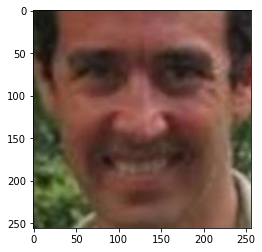

In [56]:
import matplotlib.pyplot as plt
plt.imshow(input_image[0]);

In [58]:
torch.autograd.set_detect_anomaly(True)
trainer.train()

In [59]:
input_image = input_images[10]
input_image.shape

torch.Size([3, 256, 256])

In [60]:
input_image = input_image.permute(2, 1, 0).unsqueeze(0)
input_image.shape

torch.Size([1, 256, 256, 3])

In [61]:
out = trainer.generator.forward(
    x=input_images[5].unsqueeze(0),
    input_age=input_ages[5].type(torch.long).unsqueeze(0),
    output_age=output_ages[5].type(torch.long).unsqueeze(0)
)

out.shape

torch.Size([1, 3, 256, 256])

In [62]:
out = out.permute(0, 3, 2, 1)
out.shape

torch.Size([1, 256, 256, 3])

In [63]:
out.max(), out.min()

(tensor(1., grad_fn=<MaxBackward1>), tensor(-1., grad_fn=<MinBackward1>))

In [64]:
F.relu(out[0]).max(), F.relu(out[0]).min()

(tensor(1., grad_fn=<MaxBackward1>), tensor(0., grad_fn=<MinBackward1>))

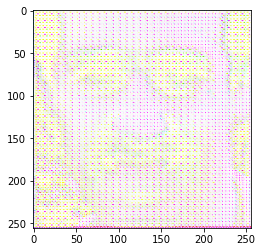

In [65]:
import numpy as np
plt.imshow(F.relu(out[0]).detach().numpy());